In [102]:
import os
import cv2
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch
import tqdm
import torch.nn as nn

In [103]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [104]:
# check device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [105]:

classes = os.listdir('Data/images_original')
classes.sort()
class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
idx_to_class = {i: cls_name for i, cls_name in enumerate(classes)}

images = []
labels = []
for i, cls_name in enumerate(classes):
    path = os.path.join('Data/images_original', cls_name)
    for img_file in os.listdir(path):
        img_path = os.path.join(path, img_file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = transform(img)
        images.append(img)
        labels.append(i)
images = torch.stack(images).to(device)
labels = torch.tensor(labels).to(device)
print(images.shape, labels.shape)

torch.Size([999, 3, 256, 256]) torch.Size([999])


In [106]:
from sklearn.model_selection import train_test_split

train_images, test_images, train_labels, test_labels = train_test_split(images, labels, shuffle=True, test_size=0.2, random_state=42)
print(train_images.shape, test_images.shape, train_labels.shape, test_labels.shape)

torch.Size([799, 3, 256, 256]) torch.Size([200, 3, 256, 256]) torch.Size([799]) torch.Size([200])


Text(0.5, 1.0, 'jazz')

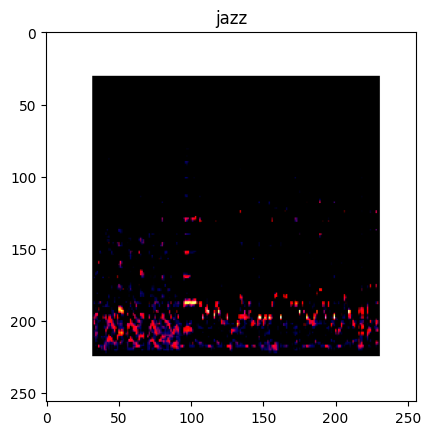

In [107]:
# print a image from the dataset
import matplotlib.pyplot as plt

plt.imshow(train_images[110].cpu().numpy().transpose(1, 2, 0))
plt.title(idx_to_class[train_labels[110].item()])

In [108]:

class MusicDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

In [109]:
dataset_train = MusicDataset(train_images, train_labels)
DataLoader_train = DataLoader(dataset_train, batch_size=50, shuffle=True)

In [110]:
import torch.nn as nn

class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x

In [125]:
model = torch.hub.load('facebookresearch/WSL-Images', 'resnext101_32x8d_wsl')
model

Using cache found in /root/.cache/torch/hub/facebookresearch_WSL-Images_main


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [126]:
for param in model.parameters():
    param.requires_grad = False


model.fc = nn.Sequential(
    nn.Linear(2048, 10, bias=True)
)

model = model.to(device)

In [127]:
# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

# 训练模型
num_epochs = 200
patience = 15  # Number of epochs to wait for improvement before stopping
best_val_loss = float('inf')  # Initialize best validation loss
patience_counter = 0  # Counter to keep track of the number of epochs without improvement
log = {}


for epoch in range(num_epochs):
    model.train()
    run_loss = 0.0
    for images, labels in tqdm.tqdm(DataLoader_train):
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        run_loss += loss.item()

    model.eval()
    with torch.no_grad():
        test_outputs = model(test_images)
        test_loss = criterion(test_outputs, test_labels)
        pred = torch.argmax(test_outputs, dim=1)
        acc = (pred == test_labels).sum().item() / len(test_labels)

        # save the loss and accuracy
        log[epoch] = {'loss_train': loss.item(), 'loss_val': test_loss.item(), 'accuracy_val': acc}
        print(f'Epoch {epoch}, loss_train: {loss.item() / len(DataLoader_train)}, loss_val: {test_loss.item()}, accuracy_val: {acc}')

    if test_loss < best_val_loss:
        best_val_loss = test_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'find-tuned-resnext.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch}')
            break

100%|██████████| 16/16 [00:04<00:00,  3.33it/s]


Epoch 0, loss_train: 0.11478875577449799, loss_val: 1.881117820739746, accuracy_val: 0.365


100%|██████████| 16/16 [00:04<00:00,  3.31it/s]


Epoch 1, loss_train: 0.10236429423093796, loss_val: 1.623960018157959, accuracy_val: 0.43


100%|██████████| 16/16 [00:04<00:00,  3.31it/s]


Epoch 2, loss_train: 0.08984575420618057, loss_val: 1.5840507745742798, accuracy_val: 0.43


100%|██████████| 16/16 [00:04<00:00,  3.33it/s]


Epoch 3, loss_train: 0.0701548308134079, loss_val: 1.4702978134155273, accuracy_val: 0.51


100%|██████████| 16/16 [00:04<00:00,  3.34it/s]


Epoch 4, loss_train: 0.063980832695961, loss_val: 1.4157978296279907, accuracy_val: 0.52


100%|██████████| 16/16 [00:04<00:00,  3.34it/s]


Epoch 5, loss_train: 0.071120984852314, loss_val: 1.388016700744629, accuracy_val: 0.535


100%|██████████| 16/16 [00:04<00:00,  3.34it/s]


Epoch 6, loss_train: 0.05186191946268082, loss_val: 1.3330879211425781, accuracy_val: 0.55


100%|██████████| 16/16 [00:04<00:00,  3.35it/s]


Epoch 7, loss_train: 0.07001405209302902, loss_val: 1.3291757106781006, accuracy_val: 0.545


100%|██████████| 16/16 [00:04<00:00,  3.36it/s]


Epoch 8, loss_train: 0.052440617233514786, loss_val: 1.3430793285369873, accuracy_val: 0.54


100%|██████████| 16/16 [00:04<00:00,  3.35it/s]


Epoch 9, loss_train: 0.05039546266198158, loss_val: 1.3121562004089355, accuracy_val: 0.565


100%|██████████| 16/16 [00:04<00:00,  3.36it/s]


Epoch 10, loss_train: 0.05532374978065491, loss_val: 1.2949752807617188, accuracy_val: 0.59


100%|██████████| 16/16 [00:04<00:00,  3.37it/s]


Epoch 11, loss_train: 0.041720181703567505, loss_val: 1.2665438652038574, accuracy_val: 0.565


100%|██████████| 16/16 [00:04<00:00,  3.36it/s]


Epoch 12, loss_train: 0.056451015174388885, loss_val: 1.2961713075637817, accuracy_val: 0.58


100%|██████████| 16/16 [00:04<00:00,  3.35it/s]


Epoch 13, loss_train: 0.042470533400774, loss_val: 1.2772961854934692, accuracy_val: 0.595


100%|██████████| 16/16 [00:04<00:00,  3.35it/s]


Epoch 14, loss_train: 0.03477953001856804, loss_val: 1.2607040405273438, accuracy_val: 0.6


100%|██████████| 16/16 [00:04<00:00,  3.34it/s]


Epoch 15, loss_train: 0.04371544346213341, loss_val: 1.2763592004776, accuracy_val: 0.605


100%|██████████| 16/16 [00:04<00:00,  3.33it/s]


Epoch 16, loss_train: 0.03188919648528099, loss_val: 1.2411961555480957, accuracy_val: 0.6


100%|██████████| 16/16 [00:04<00:00,  3.33it/s]


Epoch 17, loss_train: 0.03942263126373291, loss_val: 1.225676417350769, accuracy_val: 0.57


100%|██████████| 16/16 [00:04<00:00,  3.34it/s]


Epoch 18, loss_train: 0.0313294492661953, loss_val: 1.2657263278961182, accuracy_val: 0.575


100%|██████████| 16/16 [00:04<00:00,  3.33it/s]


Epoch 19, loss_train: 0.03801688551902771, loss_val: 1.265925645828247, accuracy_val: 0.555


100%|██████████| 16/16 [00:04<00:00,  3.34it/s]


Epoch 20, loss_train: 0.04068251699209213, loss_val: 1.3039536476135254, accuracy_val: 0.565


100%|██████████| 16/16 [00:04<00:00,  3.33it/s]


Epoch 21, loss_train: 0.04244745895266533, loss_val: 1.3284536600112915, accuracy_val: 0.55


100%|██████████| 16/16 [00:04<00:00,  3.34it/s]


Epoch 22, loss_train: 0.029833542183041573, loss_val: 1.2515047788619995, accuracy_val: 0.59


100%|██████████| 16/16 [00:04<00:00,  3.34it/s]


Epoch 23, loss_train: 0.027373570948839188, loss_val: 1.263946533203125, accuracy_val: 0.565


100%|██████████| 16/16 [00:04<00:00,  3.34it/s]


Epoch 24, loss_train: 0.026955127716064453, loss_val: 1.2406082153320312, accuracy_val: 0.625


100%|██████████| 16/16 [00:04<00:00,  3.34it/s]


Epoch 25, loss_train: 0.02348511479794979, loss_val: 1.2290540933609009, accuracy_val: 0.605


100%|██████████| 16/16 [00:04<00:00,  3.35it/s]


Epoch 26, loss_train: 0.022513793781399727, loss_val: 1.2188948392868042, accuracy_val: 0.58


100%|██████████| 16/16 [00:04<00:00,  3.36it/s]


Epoch 27, loss_train: 0.021640747785568237, loss_val: 1.2370779514312744, accuracy_val: 0.575


100%|██████████| 16/16 [00:04<00:00,  3.34it/s]


Epoch 28, loss_train: 0.02623559720814228, loss_val: 1.2319504022598267, accuracy_val: 0.61


100%|██████████| 16/16 [00:04<00:00,  3.34it/s]


Epoch 29, loss_train: 0.019909586757421494, loss_val: 1.2323893308639526, accuracy_val: 0.585


100%|██████████| 16/16 [00:04<00:00,  3.34it/s]


Epoch 30, loss_train: 0.021964065730571747, loss_val: 1.2564337253570557, accuracy_val: 0.59


100%|██████████| 16/16 [00:04<00:00,  3.34it/s]


Epoch 31, loss_train: 0.014908966608345509, loss_val: 1.2490363121032715, accuracy_val: 0.61


100%|██████████| 16/16 [00:04<00:00,  3.33it/s]


Epoch 32, loss_train: 0.022232089191675186, loss_val: 1.2567737102508545, accuracy_val: 0.6


100%|██████████| 16/16 [00:04<00:00,  3.34it/s]


Epoch 33, loss_train: 0.016659043729305267, loss_val: 1.2478070259094238, accuracy_val: 0.59


100%|██████████| 16/16 [00:04<00:00,  3.34it/s]


Epoch 34, loss_train: 0.020477300509810448, loss_val: 1.2099888324737549, accuracy_val: 0.615


100%|██████████| 16/16 [00:04<00:00,  3.34it/s]


Epoch 35, loss_train: 0.017279377207159996, loss_val: 1.280646800994873, accuracy_val: 0.595


100%|██████████| 16/16 [00:04<00:00,  3.34it/s]


Epoch 36, loss_train: 0.018698308616876602, loss_val: 1.2106356620788574, accuracy_val: 0.615


100%|██████████| 16/16 [00:04<00:00,  3.34it/s]


Epoch 37, loss_train: 0.01820881851017475, loss_val: 1.263532280921936, accuracy_val: 0.615


100%|██████████| 16/16 [00:04<00:00,  3.33it/s]


Epoch 38, loss_train: 0.013737893663346767, loss_val: 1.2671102285385132, accuracy_val: 0.585


100%|██████████| 16/16 [00:04<00:00,  3.34it/s]


Epoch 39, loss_train: 0.018050305545330048, loss_val: 1.321760654449463, accuracy_val: 0.595


100%|██████████| 16/16 [00:04<00:00,  3.34it/s]


Epoch 40, loss_train: 0.014775656163692474, loss_val: 1.2316690683364868, accuracy_val: 0.61


100%|██████████| 16/16 [00:04<00:00,  3.34it/s]


Epoch 41, loss_train: 0.012327042408287525, loss_val: 1.2682759761810303, accuracy_val: 0.605


100%|██████████| 16/16 [00:04<00:00,  3.34it/s]


Epoch 42, loss_train: 0.01849776692688465, loss_val: 1.242411494255066, accuracy_val: 0.6


100%|██████████| 16/16 [00:04<00:00,  3.34it/s]


Epoch 43, loss_train: 0.014365823939442635, loss_val: 1.2163028717041016, accuracy_val: 0.615


100%|██████████| 16/16 [00:04<00:00,  3.34it/s]


Epoch 44, loss_train: 0.012473024427890778, loss_val: 1.297045111656189, accuracy_val: 0.62


100%|██████████| 16/16 [00:04<00:00,  3.34it/s]


Epoch 45, loss_train: 0.010219295509159565, loss_val: 1.2619719505310059, accuracy_val: 0.625


100%|██████████| 16/16 [00:04<00:00,  3.34it/s]


Epoch 46, loss_train: 0.01081455685198307, loss_val: 1.2433280944824219, accuracy_val: 0.6


100%|██████████| 16/16 [00:04<00:00,  3.34it/s]


Epoch 47, loss_train: 0.012277667410671711, loss_val: 1.2631555795669556, accuracy_val: 0.59


100%|██████████| 16/16 [00:04<00:00,  3.34it/s]


Epoch 48, loss_train: 0.01071406714618206, loss_val: 1.27071213722229, accuracy_val: 0.59


100%|██████████| 16/16 [00:04<00:00,  3.34it/s]


Epoch 49, loss_train: 0.010659119114279747, loss_val: 1.263744831085205, accuracy_val: 0.595
Early stopping at epoch 49


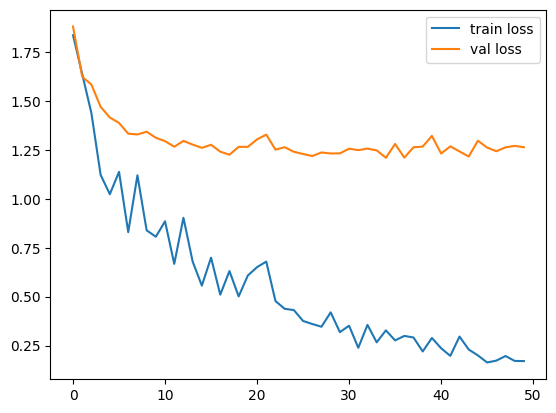

In [128]:
# draw the loss and accuracy
import matplotlib.pyplot as plt
plt.figure()
plt.plot([log[k]['loss_train'] for k in log], label='train loss')
plt.plot([log[k]['loss_val'] for k in log], label='val loss')
plt.legend()
plt.show()

In [130]:
# load the model
model.load_state_dict(torch.load('find-tuned-resnext.pth'))

# test the model
model.eval()
from sklearn.metrics import classification_report

print(classification_report(test_labels.detach().cpu().numpy(), torch.argmax(model(test_images), dim=1).detach().cpu().numpy()))

              precision    recall  f1-score   support

           0       0.71      0.48      0.57        21
           1       0.75      1.00      0.86        12
           2       0.57      0.54      0.55        24
           3       0.45      0.45      0.45        22
           4       0.65      0.87      0.74        15
           5       0.67      0.81      0.73        27
           6       0.82      0.78      0.80        18
           7       0.59      0.68      0.63        19
           8       0.58      0.50      0.54        22
           9       0.36      0.25      0.29        20

    accuracy                           0.61       200
   macro avg       0.62      0.64      0.62       200
weighted avg       0.61      0.61      0.60       200

